In [67]:
%matplotlib inline

# autoload
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import logit
from scipy.optimize import minimize
from tqdm import tqdm

# append paths
sys.path.append('../')
sys.path.append('../../')

# local imports
from process.tables import *
from models.bayes import *
from models.predict import *
from process.config import *
from process.measurements import cutoff_measurements_df
from models.ornstein_uhlenbeck import (
    run_ou_with_prior,
    estimate_ou_parameters_with_prior
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
measurements = pd.read_csv('../data/processed/lab_measurements.csv')
measurements['sex'] = measurements['gender_concept_id'].map(lambda x: 'M' if x == 0 else 'F')
processed_df = cutoff_measurements_df(measurements, percent=0.8, min_tests=3)

def get_priors_dict():
    priors = {
    (test, sex): {
        'mean': (low + high) / 2,
        'var': ((high - low) / 4)**2
    }
    for test, intervals in REFERENCE_INTERVALS.items()
        for sex, (low, high, _) in intervals.items()
    }
    return priors


Filtering Sequences:  96%|█████████▌| 146384/152269 [00:36<00:01, 3961.54it/s]


In [68]:
def get_priors_dict():
    priors = {
    (test, sex): {
        'mean': (low + high) / 2,
        'var': ((high - low) / 4)**2
    }
    for test, intervals in REFERENCE_INTERVALS.items()
        for sex, (low, high, _) in intervals.items()
    }
    return priors


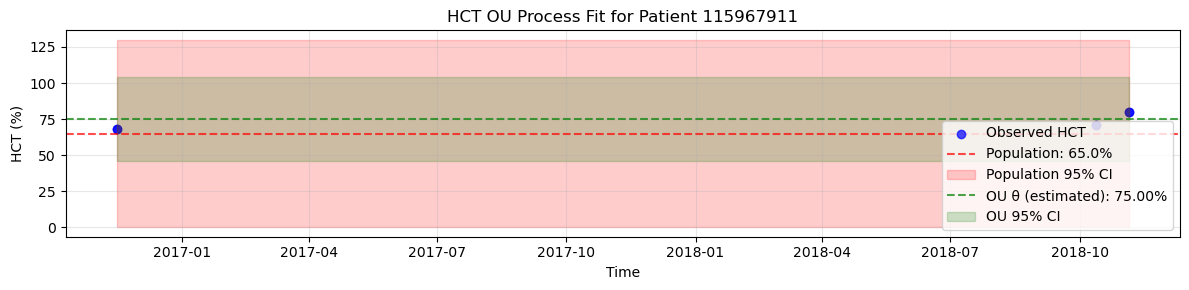

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115967911:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 75.00%
Estimated μ (OU): 1.0000
Estimated σ (OU): 20.50%
Difference from prior θ: 10.00%
Difference from prior σ: -12.00%


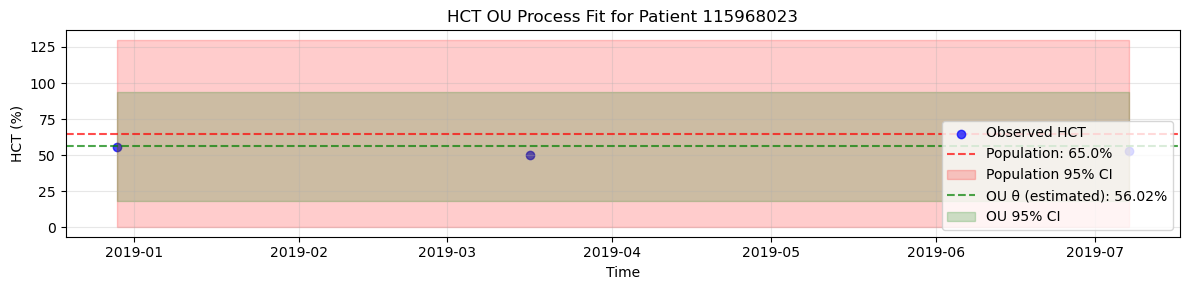

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968023:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 56.02%
Estimated μ (OU): 1.0000
Estimated σ (OU): 26.68%
Difference from prior θ: -8.98%
Difference from prior σ: -5.82%


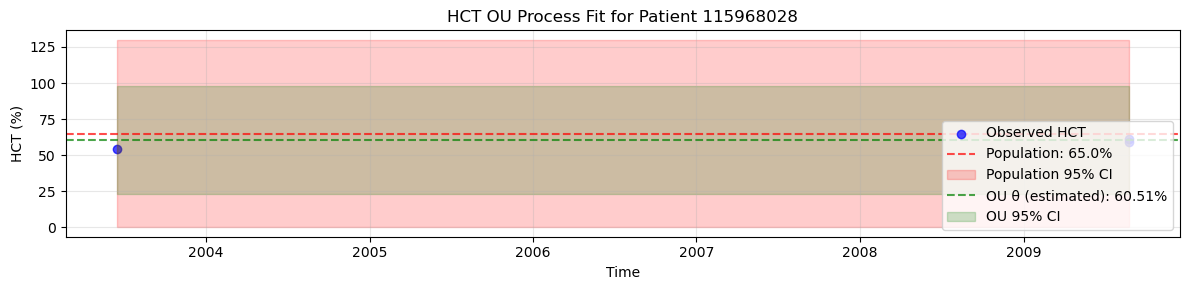

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968028:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 60.51%
Estimated μ (OU): 1.0000
Estimated σ (OU): 26.63%
Difference from prior θ: -4.49%
Difference from prior σ: -5.87%


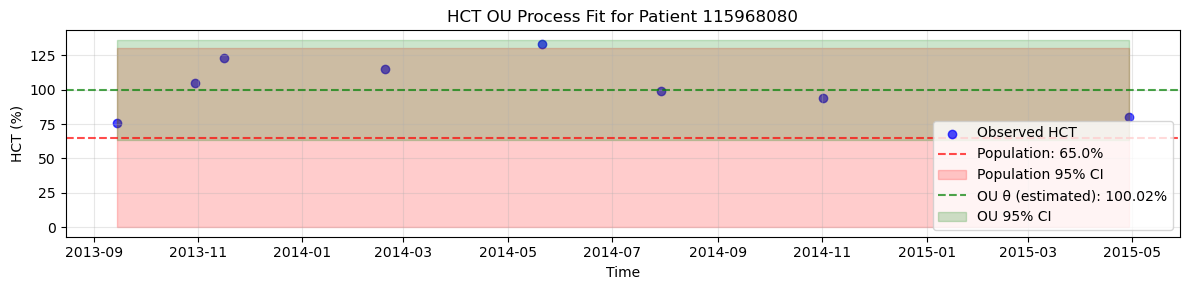

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968080:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 100.02%
Estimated μ (OU): 1.0000
Estimated σ (OU): 25.63%
Difference from prior θ: 35.02%
Difference from prior σ: -6.87%


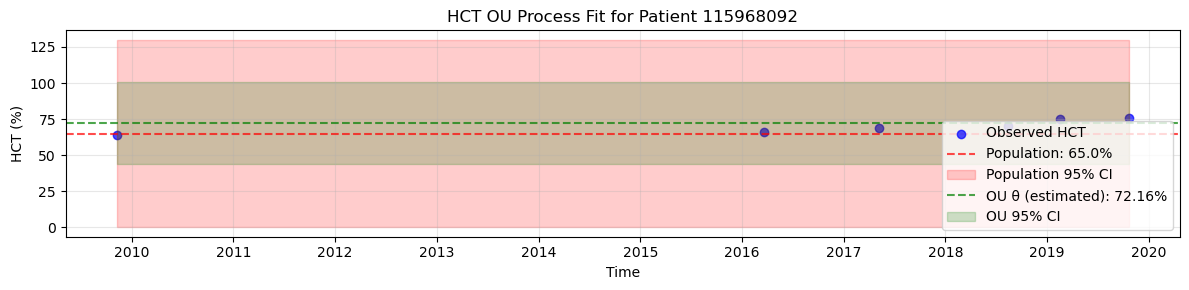

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968092:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 72.16%
Estimated μ (OU): 1.0000
Estimated σ (OU): 20.08%
Difference from prior θ: 7.16%
Difference from prior σ: -12.42%


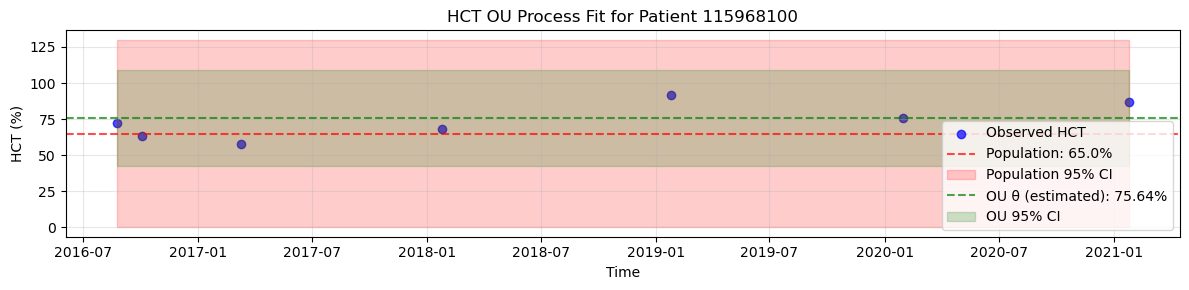

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968100:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 75.64%
Estimated μ (OU): 1.0000
Estimated σ (OU): 23.53%
Difference from prior θ: 10.64%
Difference from prior σ: -8.97%


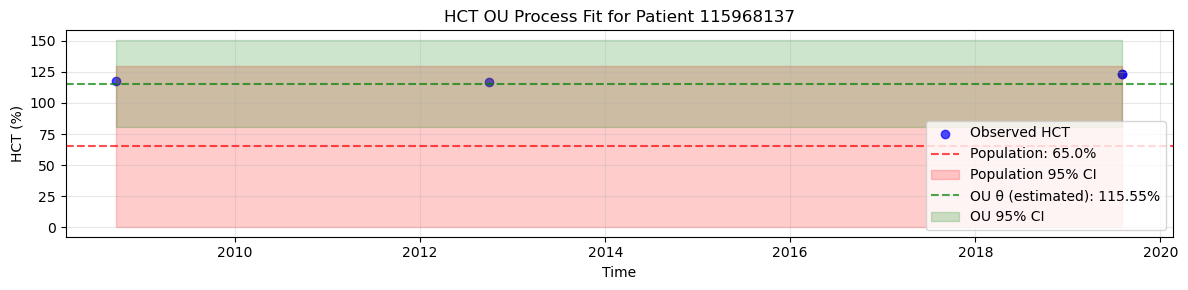

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968137:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 115.55%
Estimated μ (OU): 1.0000
Estimated σ (OU): 24.95%
Difference from prior θ: 50.55%
Difference from prior σ: -7.55%


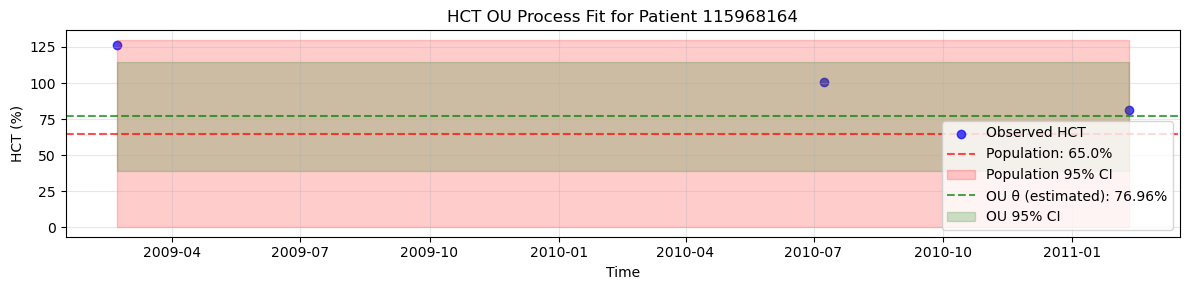

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968164:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 76.96%
Estimated μ (OU): 1.0000
Estimated σ (OU): 26.73%
Difference from prior θ: 11.96%
Difference from prior σ: -5.77%


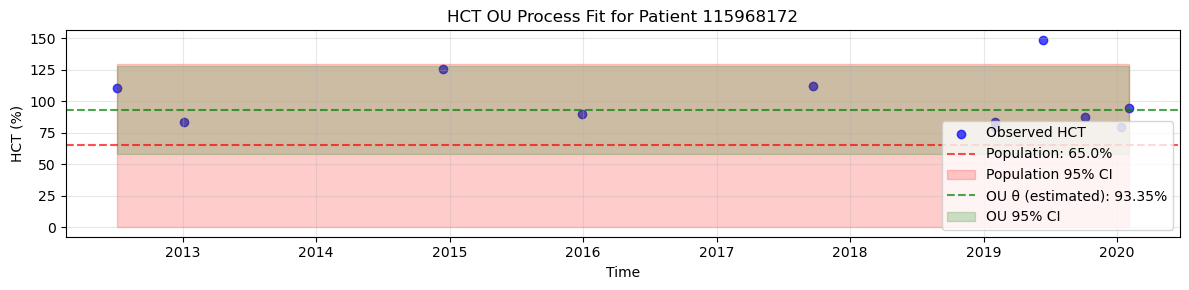

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968172:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 93.35%
Estimated μ (OU): 1.0000
Estimated σ (OU): 24.67%
Difference from prior θ: 28.35%
Difference from prior σ: -7.83%


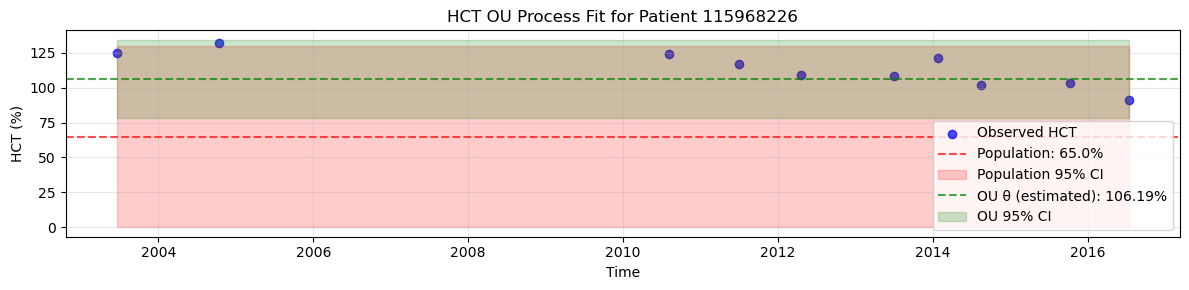

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968226:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 106.19%
Estimated μ (OU): 1.0000
Estimated σ (OU): 19.86%
Difference from prior θ: 41.19%
Difference from prior σ: -12.64%


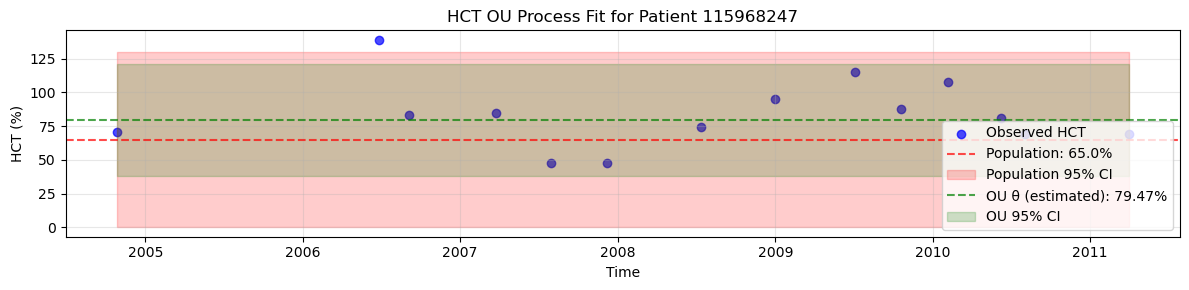

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968247:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 79.47%
Estimated μ (OU): 1.0000
Estimated σ (OU): 29.19%
Difference from prior θ: 14.47%
Difference from prior σ: -3.31%


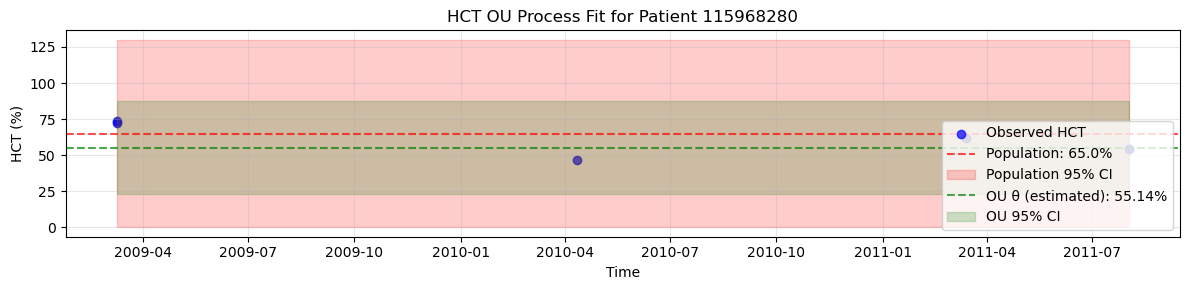

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968280:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 55.14%
Estimated μ (OU): 1.0000
Estimated σ (OU): 22.77%
Difference from prior θ: -9.86%
Difference from prior σ: -9.73%


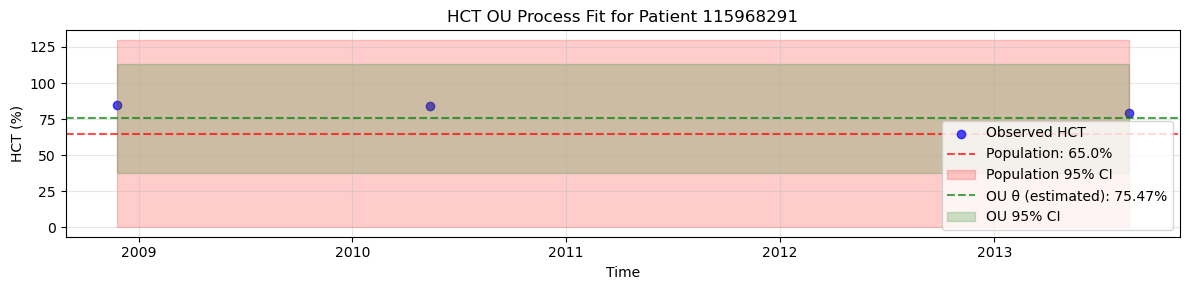

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968291:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 75.47%
Estimated μ (OU): 1.0000
Estimated σ (OU): 26.70%
Difference from prior θ: 10.47%
Difference from prior σ: -5.80%


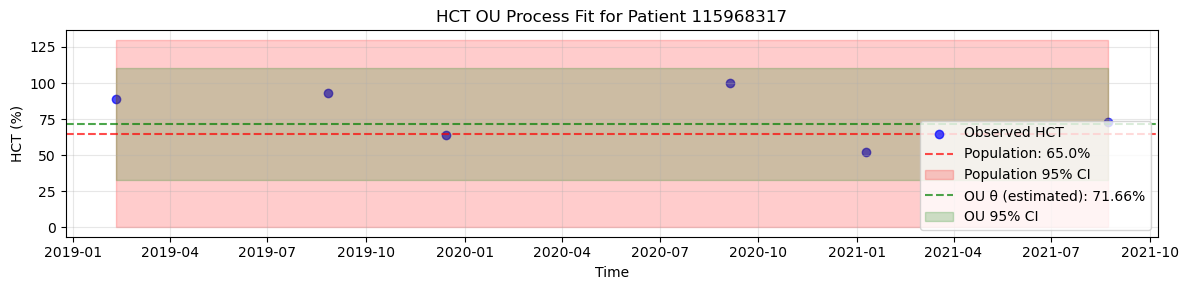

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968317:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 71.66%
Estimated μ (OU): 1.0000
Estimated σ (OU): 27.46%
Difference from prior θ: 6.66%
Difference from prior σ: -5.04%


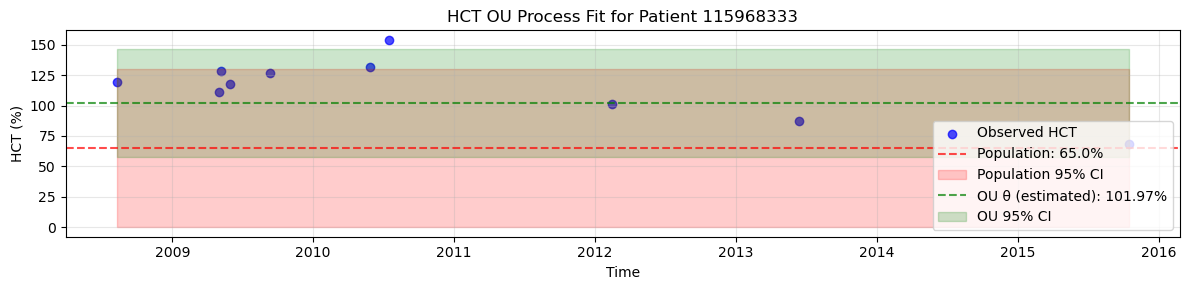

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968333:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 101.97%
Estimated μ (OU): 0.8825
Estimated σ (OU): 29.41%
Difference from prior θ: 36.97%
Difference from prior σ: -3.09%


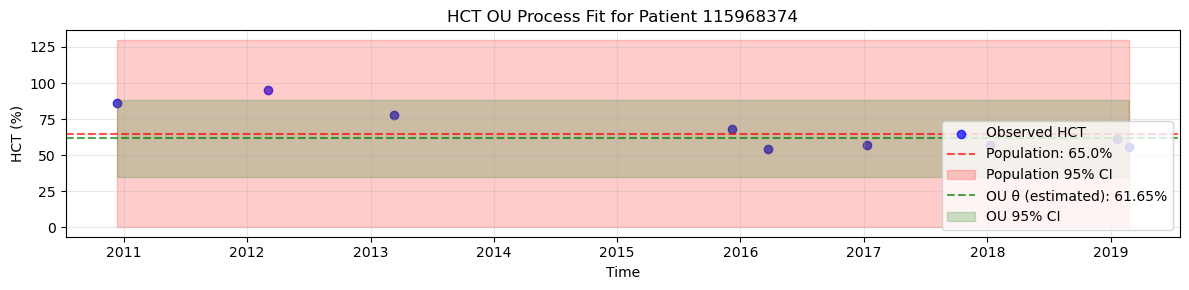

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968374:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 61.65%
Estimated μ (OU): 1.0000
Estimated σ (OU): 18.77%
Difference from prior θ: -3.35%
Difference from prior σ: -13.73%


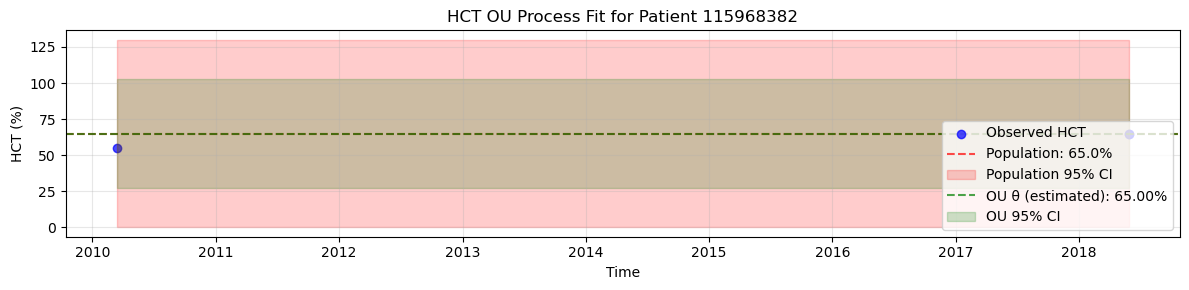

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968382:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 65.00%
Estimated μ (OU): 1.0000
Estimated σ (OU): 26.61%
Difference from prior θ: 0.00%
Difference from prior σ: -5.89%


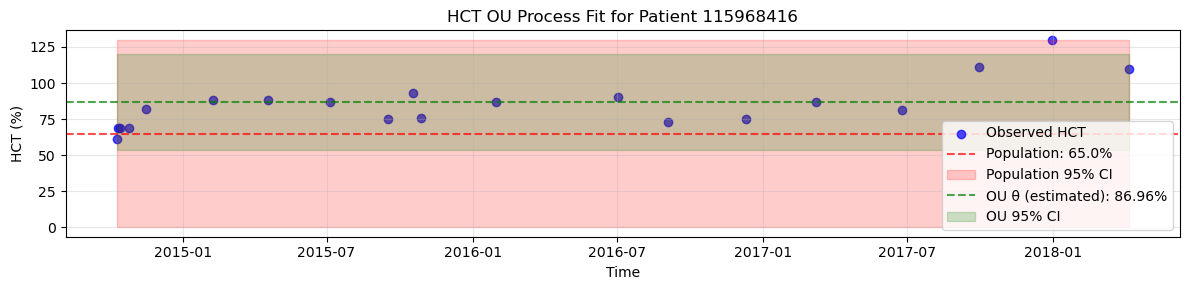

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968416:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 86.96%
Estimated μ (OU): 1.0000
Estimated σ (OU): 23.43%
Difference from prior θ: 21.96%
Difference from prior σ: -9.07%


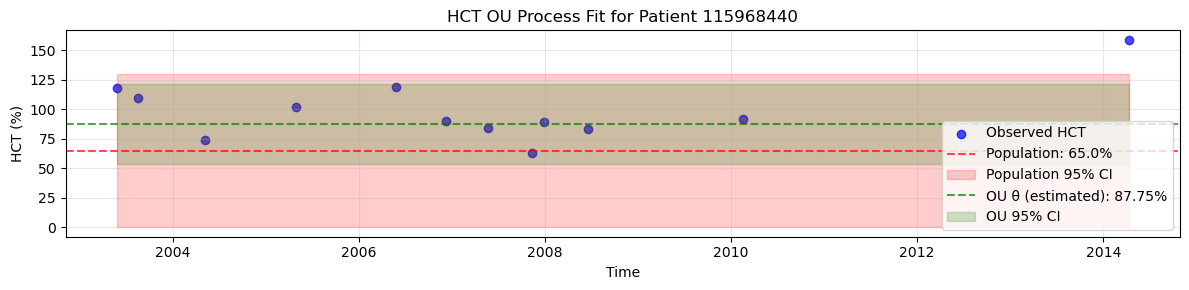

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968440:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 87.75%
Estimated μ (OU): 1.0000
Estimated σ (OU): 24.12%
Difference from prior θ: 22.75%
Difference from prior σ: -8.38%


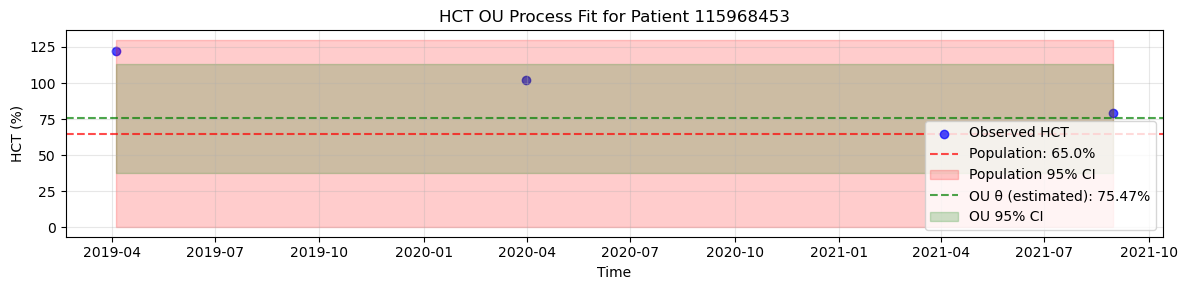

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968453:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 75.47%
Estimated μ (OU): 1.0000
Estimated σ (OU): 26.70%
Difference from prior θ: 10.47%
Difference from prior σ: -5.80%


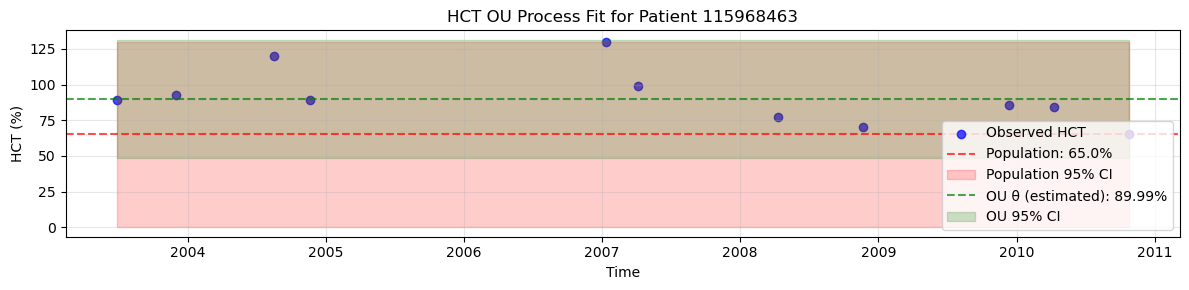

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968463:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 89.99%
Estimated μ (OU): 1.0000
Estimated σ (OU): 29.25%
Difference from prior θ: 24.99%
Difference from prior σ: -3.25%


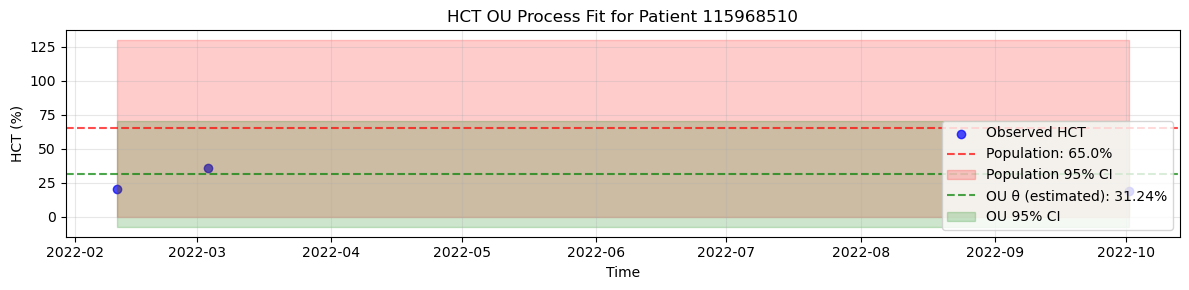

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968510:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 31.24%
Estimated μ (OU): 1.0000
Estimated σ (OU): 27.67%
Difference from prior θ: -33.76%
Difference from prior σ: -4.83%


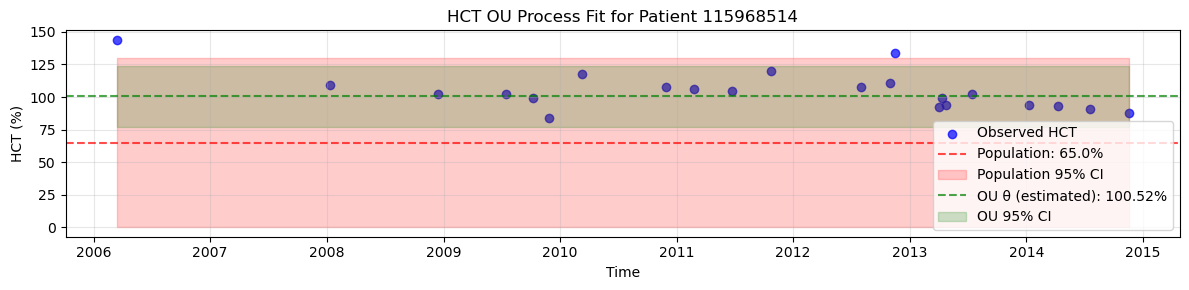

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968514:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 100.52%
Estimated μ (OU): 1.0000
Estimated σ (OU): 16.63%
Difference from prior θ: 35.52%
Difference from prior σ: -15.87%


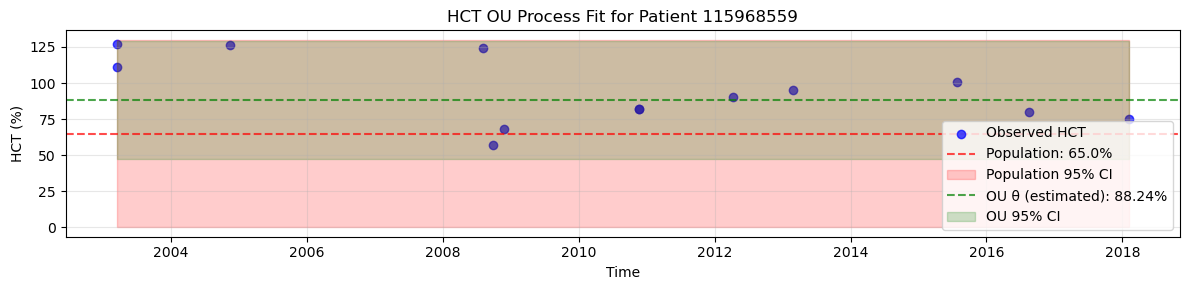

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968559:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 88.24%
Estimated μ (OU): 1.0000
Estimated σ (OU): 29.12%
Difference from prior θ: 23.24%
Difference from prior σ: -3.38%


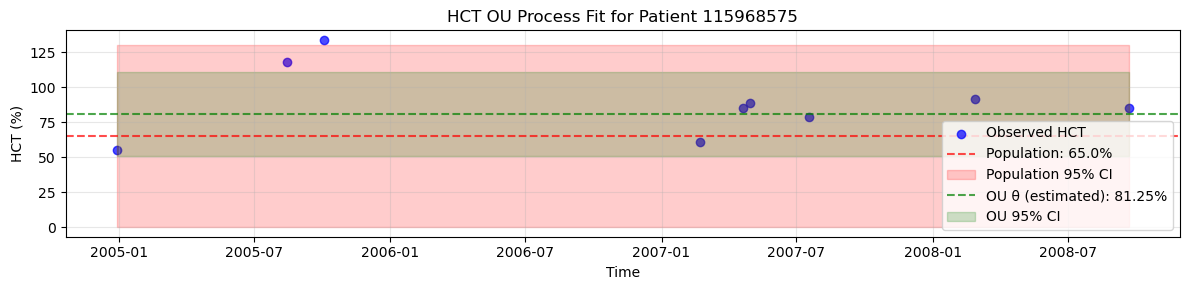

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968575:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 81.25%
Estimated μ (OU): 1.0000
Estimated σ (OU): 21.24%
Difference from prior θ: 16.25%
Difference from prior σ: -11.26%


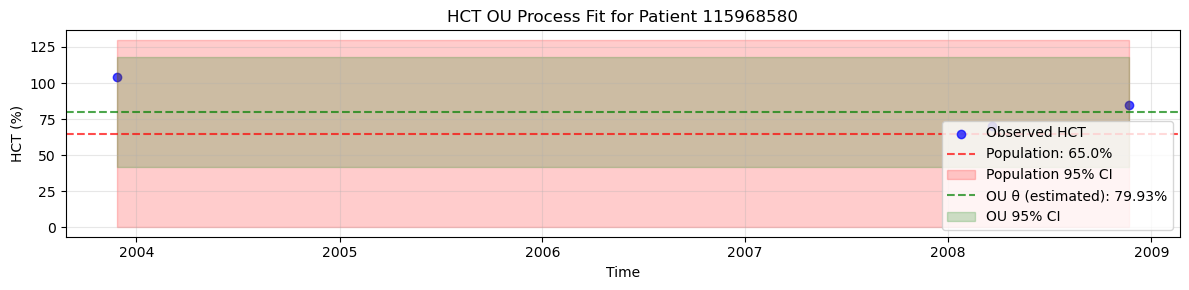

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968580:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 79.93%
Estimated μ (OU): 1.0000
Estimated σ (OU): 26.80%
Difference from prior θ: 14.93%
Difference from prior σ: -5.70%


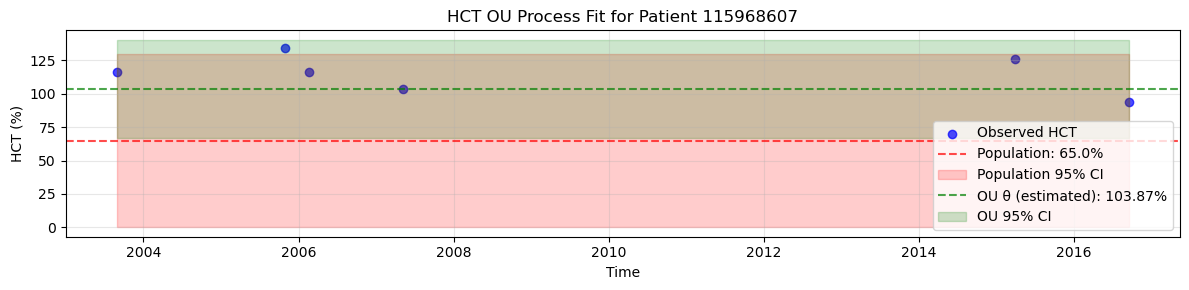

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968607:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 103.87%
Estimated μ (OU): 1.0000
Estimated σ (OU): 25.94%
Difference from prior θ: 38.87%
Difference from prior σ: -6.56%


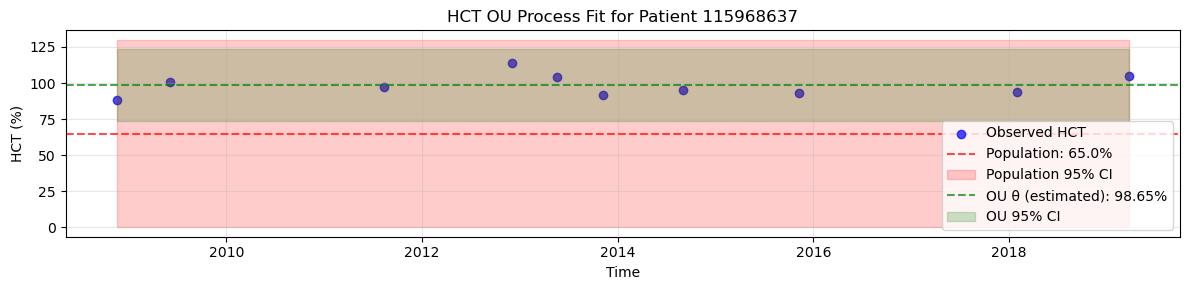

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968637:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 98.65%
Estimated μ (OU): 1.0000
Estimated σ (OU): 17.41%
Difference from prior θ: 33.65%
Difference from prior σ: -15.09%


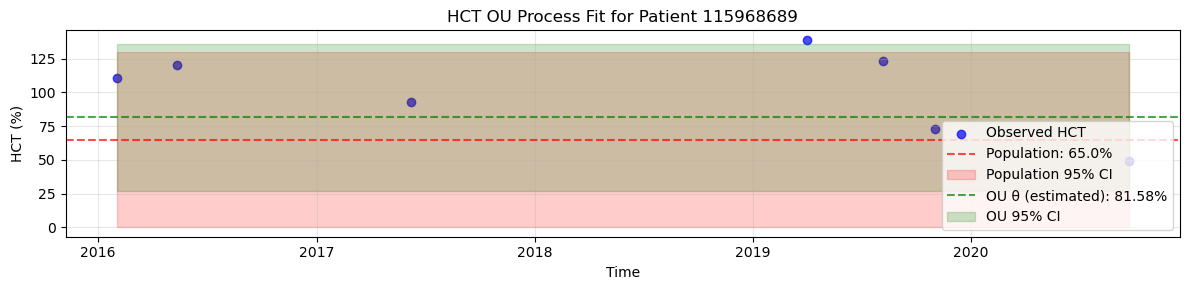

   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  

Comparison for subject 115968689:
Prior θ mean: 65.0%
Prior σ mean: 32.5%
Estimated θ (OU): 81.58%
Estimated μ (OU): 0.5802
Estimated σ (OU): 29.41%
Difference from prior θ: 16.58%
Difference from prior σ: -3.09%


In [79]:
subject = 115967127
test_name = 'LDL'
subjects = processed_df.query('test_name == @test_name')['subject_id'].unique()[50:90]

priors = get_priors_dict()

for subject in subjects:
    sample = processed_df.query('subject_id == @subject and test_name == @test_name') #[['time', 'numeric_value', 'sex']]
    sample = sample[['time', 'numeric_value', 'sex']]
    sex = sample['sex'].unique()[0]
    
    # only use points in the range
    
    # Get priors properly
    if (test_name, sex) in priors:
        prior_mean = priors[(test_name, sex)]['mean']
        prior_var = priors[(test_name, sex)]['var']
    else:
        # Fallback if test/sex combination not found
        prior_mean = sample['numeric_value'].mean()
        prior_var = sample['numeric_value'].var()

    
    # Set sigma prior based on data variability
    prior_sigma_mean = np.sqrt(priors[(test_name, sex)]['var'])
    prior_sigma_var = 0.1  # More reasonable log-variance

    filtered_sample = sample[sample['numeric_value'].between(prior_mean - 2 * prior_sigma_mean, prior_mean + 2 * prior_sigma_mean)]     
    df = filtered_sample.copy()
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time')
    df['dt'] = df['time'].diff().dt.total_seconds().div(86400)
    df = df.dropna()
    
    if len(df) < 2:  # Need at least 2 points for OU
        continue
        
    S = df['numeric_value'].values
    dt = df['dt'].mean()
    
    theta_ml, mu_ml, sigma_ml = estimate_ou_parameters_with_prior(
        S, dt, prior_mean, prior_var, prior_sigma_mean, prior_sigma_var
    )
        
    # Plot results
    plt.figure(figsize=(12, 3))
    plt.scatter(sample['time'], sample['numeric_value'], color='blue', alpha=0.7, label='Observed HCT')

    std_dev = prior_sigma_mean
    confidence_interval = 2 * std_dev

    plt.axhline(prior_mean, color='red', linestyle='--', alpha=0.7, label=f'Population: {prior_mean:.1f}%')
    plt.fill_between(sample['time'], prior_mean - confidence_interval, prior_mean + confidence_interval,
                     color='red', alpha=0.2, label='Population 95% CI')

    ou_std_dev = min(prior_sigma_mean, sigma_ml / np.sqrt(2 * mu_ml))

    plt.axhline(theta_ml, color='green', linestyle='--', alpha=0.7, label=f'OU θ (estimated): {theta_ml:.2f}%')
    plt.fill_between(sample['time'], theta_ml - 2 * ou_std_dev, theta_ml + 2 * ou_std_dev,
                     color='green', alpha=0.2, label='OU 95% CI')

    plt.title(f'HCT OU Process Fit for Patient {subject}')
    plt.xlabel('Time')
    plt.ylabel('HCT (%)')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("   'HCT': {'F': (37, 47, '%'), 'M': (42, 50, '%')},  ")
    print(f"\nComparison for subject {subject}:")
    print(f"Prior θ mean: {prior_mean:.1f}%")
    print(f"Prior σ mean: {prior_sigma_mean:.1f}%")
    print(f"Estimated θ (OU): {theta_ml:.2f}%")
    print(f"Estimated μ (OU): {mu_ml:.4f}")
    print(f"Estimated σ (OU): {sigma_ml:.2f}%")
    print(f"Difference from prior θ: {theta_ml - prior_mean:.2f}%")
    print(f"Difference from prior σ: {sigma_ml - prior_sigma_mean:.2f}%")


In [18]:
subject = processed_df.query('test_name == @test_name')['subject_id'].unique()[:1]
sample = processed_df.query('subject_id == @subject and test_name == @test_name')[['time', 'numeric_value']]
print(sample)

Empty DataFrame
Columns: [time, numeric_value]
Index: []
